# Structured and time series data

This notebook contains an implementation of the third place result in the Rossman Kaggle competition as detailed in Guo/Berkhahn's [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737).

The motivation behind exploring this architecture is it's relevance to real-world application. Most data used for decision making day-to-day in industry is structured and/or time-series data. Here we explore the end-to-end process of using neural networks with practical structured data problems.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/rossman/'

## Create datasets

In addition to the provided data, we will be using external datasets put together by participants in the Kaggle competition. You can download all of them [here](http://files.fast.ai/part2/lesson14/rossmann.tgz).

For completeness, the implementation used to put them together is included below.

In [8]:
def concat_csvs(dirname):
    path = f'{PATH}{dirname}'
    filenames=glob(f"{PATH}/*.csv")

    wrote_header = False
    with open(f"{path}.csv","w") as outputfile:
        for filename in filenames:
            name = filename.split(".")[0]
            with open(filename) as f:
                line = f.readline()
                if not wrote_header:
                    wrote_header = True
                    outputfile.write("file,"+line)
                for line in f:
                     outputfile.write(name + "," + line)
                outputfile.write("\n")

In [11]:
# concat_csvs('googletrend')
# concat_csvs('weather')

Feature Space:
* train: Training set provided by competition
* store: List of stores
* store_states: mapping of store to the German state they are in
* List of German state names
* googletrend: trend of certain google keywords over time, found by users to correlate well w/ given data
* weather: weather
* test: testing set

In [9]:
table_names = ['train', 'store', 'store_states', 'state_names',
               'googletrend', 'weather', 'test']

We'll be using the popular data manipulation framework `pandas`. Among other things, pandas allows you to manipulate tables/data frames in python as one would in a database.

We're going to go ahead and load all of our csv's as dataframes into the list `tables`.

In [10]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [11]:
tables[4].head()

file                     week  trend
0  Rossmann_DE_SN  2012-12-02 - 2012-12-08     96
1  Rossmann_DE_SN  2012-12-09 - 2012-12-15     95
2  Rossmann_DE_SN  2012-12-16 - 2012-12-22     91
3  Rossmann_DE_SN  2012-12-23 - 2012-12-29     48
4  Rossmann_DE_SN  2012-12-30 - 2013-01-05     67

In [12]:
from IPython.display import HTML

We can use `head()` to get a quick look at the contents of each table:
* train: Contains store information on a daily basis, tracks things like sales, customers, whether that day was a holdiay, etc.
* store: general info about the store including competition, etc.
* store_states: maps store to state it is in
* state_names: Maps state abbreviations to names
* googletrend: trend data for particular week/state
* weather: weather conditions for each state
* test: Same as training table, w/o sales and customers


In [13]:
for t in tables: display(t.head())

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

Store State
0      1    HE
1      2    TH
2      3    NW
3      4    BE
4      5    SN

StateName State
0  BadenWuerttemberg    BW
1             Bayern    BY
2             Berlin    BE
3        Brandenburg    BB
4             Bremen    HB

file                     week  trend
0  Rossmann_DE_SN  2012-12-02 - 2012-12-08     96
1  Rossmann_DE_SN  2012-12-09 - 2012-12-15     95
2  Rossmann_DE_SN  2012-12-16 - 2012-12-22     91
3  Rossmann_DE_SN  2012-12-23 - 2012-12-29     48
4  Rossmann_DE_SN  2012-12-30 - 2013-01-05     67

file        Date  Max_TemperatureC  Mean_TemperatureC  \
0  NordrheinWestfalen  2013-01-01                 8                  4   
1  NordrheinWestfalen  2013-01-02                 7                  4   
2  NordrheinWestfalen  2013-01-03                11                  8   
3  NordrheinWestfalen  2013-01-04                 9                  9   
4  NordrheinWestfalen  2013-01-05                 8                  8   

   Min_TemperatureC  Dew_PointC  MeanDew_PointC  Min_DewpointC  Max_Humidity  \
0                 2           7               5              1            94   
1                 1           5               3              2            93   
2                 6          10               8              4           100   
3                 8           9               9              8           100   
4                 7           8               7              6           100   

   Mean_Humidity       ...        Max_VisibilityKm  Mean_VisibilityKm  \
0             87       ...                    31.0               12.0   
1             85       ...                    31.0               14.0   
2             93       ...                    31.0                8.0   
3             94       ...                    11.0                5.0   
4             94       ...                    10.0                6.0   

   Min_VisibilitykM  Max_Wind_SpeedKm_h  Mean_Wind_SpeedKm_h  \
0               4.0                  39                   26   
1              10.0                  24                   16   
2               2.0                  26                   21   
3               2.0                  23                   14   
4               3.0                  16                   10   

   Max_Gust_SpeedKm_h  Precipitationmm  CloudCover  Events  WindDirDegrees  
0                58.0             5.08         6.0    Rain             215  
1                 NaN             0.00         6.0    Rain             225  
2                 NaN             1.02         7.0    Rain             240  
3                 NaN             0.25         7.0    Rain             263  
4                 NaN             0.00         7.0    Rain             268  

[5 rows x 24 columns]

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0              0
2   3      7          4  2015-09-17   1.0      1            0              0
3   4      8          4  2015-09-17   1.0      1            0              0
4   5      9          4  2015-09-17   1.0      1            0              0

This is very representative of a typical industry dataset.

The following returns summarized aggregate information to each table accross each field.

In [17]:
for t in tables: display(DataFrameSummary(t).summary())

Store    DayOfWeek         Date        Sales    Customers  \
count         1.01721e+06  1.01721e+06          NaN  1.01721e+06  1.01721e+06   
mean               558.43      3.99834          NaN      5773.82      633.146   
std               321.909      1.99739          NaN      3849.93      464.412   
min                     1            1          NaN            0            0   
25%                   280            2          NaN         3727          405   
50%                   558            4          NaN         5744          609   
75%                   838            6          NaN         7856          837   
max                  1115            7          NaN        41551         7388   
counts            1017209      1017209      1017209      1017209      1017209   
uniques              1115            7          942        21734         4086   
missing                 0            0            0            0            0   
missing_perc           0%           0%           0%           0%           0%   
types             numeric      numeric  categorical      numeric      numeric   

                     Open        Promo StateHoliday SchoolHoliday  
count         1.01721e+06  1.01721e+06          NaN   1.01721e+06  
mean             0.830107     0.381515          NaN      0.178647  
std              0.375539     0.485759          NaN      0.383056  
min                     0            0          NaN             0  
25%                     1            0          NaN             0  
50%                     1            0          NaN             0  
75%                     1            1          NaN             0  
max                     1            1          NaN             1  
counts            1017209      1017209      1017209       1017209  
uniques                 2            2            4             2  
missing                 0            0            0             0  
missing_perc           0%           0%           0%            0%  
types                bool         bool  categorical          bool

Store    StoreType   Assortment CompetitionDistance  \
count            1115          NaN          NaN                1112   
mean              558          NaN          NaN              5404.9   
std           322.017          NaN          NaN             7663.17   
min                 1          NaN          NaN                  20   
25%             279.5          NaN          NaN               717.5   
50%               558          NaN          NaN                2325   
75%             836.5          NaN          NaN              6882.5   
max              1115          NaN          NaN               75860   
counts           1115         1115         1115                1112   
uniques          1115            4            3                 654   
missing             0            0            0                   3   
missing_perc       0%           0%           0%               0.27%   
types         numeric  categorical  categorical             numeric   

             CompetitionOpenSinceMonth CompetitionOpenSinceYear    Promo2  \
count                              761                      761      1115   
mean                            7.2247                  2008.67  0.512108   
std                            3.21235                  6.19598  0.500078   
min                                  1                     1900         0   
25%                                  4                     2006         0   
50%                                  8                     2010         1   
75%                                 10                     2013         1   
max                                 12                     2015         1   
counts                             761                      761      1115   
uniques                             12                       23         2   
missing                            354                      354         0   
missing_perc                    31.75%                   31.75%        0%   
types                          numeric                  numeric      bool   

             Promo2SinceWeek Promo2SinceYear PromoInterval  
count                    571             571           NaN  
mean                 23.5954         2011.76           NaN  
std                   14.142         1.67494           NaN  
min                        1            2009           NaN  
25%                       13            2011           NaN  
50%                       22            2012           NaN  
75%                       37            2013           NaN  
max                       50            2015           NaN  
counts                   571             571           571  
uniques                   24               7             3  
missing                  544             544           544  
missing_perc          48.79%          48.79%        48.79%  
types                numeric         numeric   categorical

Store        State
count            1115          NaN
mean              558          NaN
std           322.017          NaN
min                 1          NaN
25%             279.5          NaN
50%               558          NaN
75%             836.5          NaN
max              1115          NaN
counts           1115         1115
uniques          1115           12
missing             0            0
missing_perc       0%           0%
types         numeric  categorical

StateName   State
count                    16      16
unique                   16      16
top           Niedersachsen      RP
freq                      1       1
counts                   16      16
uniques                  16      16
missing                   0       0
missing_perc             0%      0%
types                unique  unique

file         week    trend
count                 NaN          NaN     2072
mean                  NaN          NaN  63.8142
std                   NaN          NaN  12.6502
min                   NaN          NaN        0
25%                   NaN          NaN       55
50%                   NaN          NaN       64
75%                   NaN          NaN       72
max                   NaN          NaN      100
counts               2072         2072     2072
uniques                14          148       68
missing                 0            0        0
missing_perc           0%           0%       0%
types         categorical  categorical  numeric

file         Date Max_TemperatureC Mean_TemperatureC  \
count                 NaN          NaN            15840             15840   
mean                  NaN          NaN          14.6441            10.389   
std                   NaN          NaN          8.64601           7.37926   
min                   NaN          NaN              -11               -13   
25%                   NaN          NaN                8                 4   
50%                   NaN          NaN               15                11   
75%                   NaN          NaN               21                16   
max                   NaN          NaN               39                31   
counts              15840        15840            15840             15840   
uniques                16          990               51                45   
missing                 0            0                0                 0   
missing_perc           0%           0%               0%                0%   
types         categorical  categorical          numeric           numeric   

             Min_TemperatureC Dew_PointC MeanDew_PointC Min_DewpointC  \
count                   15840      15840          15840         15840   
mean                  6.19899    8.58782        6.20581       3.62614   
std                   6.52639    6.24478        6.08677       6.12839   
min                       -15        -14            -15           -73   
25%                         1          4              2            -1   
50%                         7          9              7             4   
75%                        11         13             11             8   
max                        24         25             20            19   
counts                  15840      15840          15840         15840   
uniques                    40         40             36            40   
missing                     0          0              0             0   
missing_perc               0%         0%             0%            0%   
types                 numeric    numeric        numeric       numeric   

             Max_Humidity Mean_Humidity      ...       Max_VisibilityKm  \
count               15840         15840      ...                  15459   
mean              93.6596       74.2829      ...                24.0576   
std               7.67853       13.4866      ...                 8.9768   
min                    44            30      ...                      0   
25%                 90.75            65      ...                     14   
50%                    94            76      ...                     31   
75%                   100            85      ...                     31   
max                   100           100      ...                     31   
counts              15840         15840      ...                  15459   
uniques                53            71      ...                     24   
missing                 0             0      ...                    381   
missing_perc           0%            0%      ...                  2.41%   
types             numeric       numeric      ...                numeric   

             Mean_VisibilityKm Min_VisibilitykM Max_Wind_SpeedKm_h  \
count                    15459            15459              15840   
mean                   12.2398          7.02516            22.7666   
std                    5.06794           4.9806            8.98862   
min                          0                0                  3   
25%                         10                3                 16   
50%                         11                7                 21   
75%                         14               10                 27   
max                         31               31                101   
counts                   15459            15459              15840   
uniques                     32               24                 44   
missing                    381              381                  0   
missing_perc             2.4

Id    Store DayOfWeek         Date      Open     Promo  \
count           41088    41088     41088          NaN     41077     41088   
mean          20544.5    555.9   3.97917          NaN  0.854322  0.395833   
std           11861.2  320.274   2.01548          NaN  0.352787  0.489035   
min                 1        1         1          NaN         0         0   
25%           10272.8   279.75         2          NaN         1         0   
50%           20544.5    553.5         4          NaN         1         0   
75%           30816.2   832.25         6          NaN         1         1   
max             41088     1115         7          NaN         1         1   
counts          41088    41088     41088        41088     41077     41088   
uniques         41088      856         7           48         2         2   
missing             0        0         0            0        11         0   
missing_perc       0%       0%        0%           0%     0.03%        0%   
types         numeric  numeric   numeric  categorical      bool      bool   

             StateHoliday SchoolHoliday  
count                 NaN         41088  
mean                  NaN      0.443487  
std                   NaN      0.496802  
min                   NaN             0  
25%                   NaN             0  
50%                   NaN             0  
75%                   NaN             1  
max                   NaN             1  
counts              41088         41088  
uniques                 2             2  
missing                 0             0  
missing_perc           0%            0%  
types                bool          bool

## Data Cleaning / Feature Engineering

As a structured data problem, we necessarily have to go through all the cleaning and feature engineering, even though we're using a neural network.

In [14]:
train, store, store_states, state_names, googletrend, weather, test = tables

In [15]:
len(train),len(test)

(1017209, 41088)

We turn state Holidays to booleans, to make them more convenient for modeling. We can do calculations on pandas fields using notation very similar (often identical) to numpy.

In [16]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

`join_df` is a function for joining tables on specific fields. By default, we'll be doing a left outer join of `right` on the `left` argument using the given fields for each table.

Pandas does joins using the `merge` method. The `suffixes` argument describes the naming convention for duplicate fields. We've elected to leave the duplicate field names on the left untouched, and append a "\_y" to those on the right.

In [17]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

Join weather/state names.

In [18]:
weather = join_df(weather, state_names, "file", "StateName")

In pandas you can add new columns to a dataframe by simply defining it. We'll do this for googletrends by extracting dates and state names from the given data and adding those columns.

We're also going to replace all instances of state name 'NI' to match the usage in the rest of the data: 'HB,NI'. This is a good opportunity to highlight pandas indexing. We can use `.loc[rows, cols]` to select a list of rows and a list of columns from the dataframe. In this case, we're selecting rows w/ statename 'NI' by using a boolean list `googletrend.State=='NI'` and selecting "State".

In [19]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

The following extracts particular date fields from a complete datetime for the purpose of constructing categoricals.

You should *always* consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities. We'll add to every table with a date field.

In [20]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

In [21]:
??add_datepart

The Google trends data has a special category for the whole of the Germany - we'll pull that out so we can use it explicitly.

In [26]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

Now we can outer join all of our data into a single dataframe. Recall that in outer joins everytime a value in the joining field on the left table does not have a corresponding value on the right table, the corresponding row in the new table has Null values for all right table fields. One way to check that all records are consistent and complete is to check for Null values post-join, as we do here.

*Aside*: Why note just do an inner join?
If you are assuming that all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. However, in the event you are wrong or a mistake is made, an outer join followed by a null-check will catch it. (Comparing before/after # of rows for inner join is equivalent, but requires keeping track of before/after row #'s. Outer join is easier.)

In [27]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [28]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [29]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [30]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [31]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [32]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

Next we'll fill in missing values to avoid complications with `NA`'s. `NA` (not available) is how Pandas indicates missing values; many models have problems when missing values are present, so it's always important to think about how to deal with them. In these cases, we are picking an arbitrary *signal value* that doesn't otherwise appear in the data.

In [36]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

Next we'll extract features "CompetitionOpenSince" and "CompetitionDaysOpen". Note the use of `apply()` in mapping a function across dataframe values.

In [38]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

We'll replace some erroneous / outlying data.

In [39]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

We add "CompetitionMonthsOpen" field, limiting the maximum to 2 years to limit number of unique categories.

In [40]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

Same process for Promo dates.

In [41]:
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [42]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [43]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

## Durations

It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:
* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a class to handle this type of data.

We'll define a function `get_elapsed` for cumulative counting across a sorted dataframe. Given a particular field `fld` to monitor, this function will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen. We'll see how to use this shortly.

In [45]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1).astype(int))
    df[pre+fld] = res

We'll be applying this to a subset of columns:

In [75]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [47]:
df = train[columns]

In [76]:
df = test[columns]

Let's walk through an example.

Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call `add_elapsed('SchoolHoliday', 'After')`:
This will apply to each row with School Holiday:
* A applied to every row of the dataframe in order of store and date
* Will add to the dataframe the days since seeing a School Holiday
* If we sort in the other direction, this will count the days until another holiday.

In [77]:
df.columns

Index(['Date', 'Store', 'Promo', 'StateHoliday', 'SchoolHoliday'], dtype='object')

In [78]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

We'll do this for two more fields.

In [79]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [80]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

We're going to set the active index to Date.

In [81]:
df = df.set_index("Date")

Then set null values from elapsed field calculations to 0.

In [82]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [83]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0)

Next we'll demonstrate window functions in pandas to calculate rolling quantities.

Here we're sorting by date (`sort_index()`) and counting the number of events of interest (`sum()`) defined in `columns` in the following week (`rolling()`), grouped by Store (`groupby()`). We do the same in the opposite direction.

In [84]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [85]:
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

Next we want to drop the Store indices grouped together in the window function.

Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

In [86]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [87]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [88]:
df.reset_index(inplace=True)

Now we'll merge these values onto the df.

In [89]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [90]:
df.drop(columns,1,inplace=True)

In [91]:
df.head()

Date  Store  AfterSchoolHoliday  BeforeSchoolHoliday  \
0 2015-09-17      1                  13 -9223372036854775808   
1 2015-09-16      1                  12 -9223372036854775808   
2 2015-09-15      1                  11 -9223372036854775808   
3 2015-09-14      1                  10 -9223372036854775808   
4 2015-09-13      1                   9 -9223372036854775808   

     AfterStateHoliday   BeforeStateHoliday  AfterPromo  BeforePromo  \
0 -9223372036854775808 -9223372036854775808           0            0   
1 -9223372036854775808 -9223372036854775808           0            0   
2 -9223372036854775808 -9223372036854775808           0            0   
3 -9223372036854775808 -9223372036854775808           0            0   
4 -9223372036854775808 -9223372036854775808           9           -1   

   SchoolHoliday_bw  StateHoliday_bw  Promo_bw  SchoolHoliday_fw  \
0               0.0              0.0       4.0               0.0   
1               0.0              0.0       3.0               0.0   
2               0.0              0.0       2.0               0.0   
3               0.0              0.0       1.0               0.0   
4               0.0              0.0       0.0               0.0   

   StateHoliday_fw  Promo_fw  
0              0.0       1.0  
1              0.0       2.0  
2              0.0       3.0  
3              0.0       4.0  
4              0.0       4.0

It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.

In [92]:
df.to_feather(f'{PATH}df')

In [93]:
ls {PATH}

df*               models/                 store.csv*         weather.csv*
googletrend.csv*  rossmann.tgz*           store_states.csv*
joined*           sample_submission.csv*  test.csv*
joined_test*      state_names.csv*        train.csv*


In [47]:
df = pd.read_feather(f'{PATH}df')

TypeError: read_feather() got an unexpected keyword argument 'index_col'

In [94]:
df["Date"] = pd.to_datetime(df.Date)

In [95]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [96]:
joined = join_df(joined, df, ['Store', 'Date'])

In [97]:
joined_test = join_df(joined_test, df, ['Store', 'Date'])

The authors also removed all instances where the store had zero sale / was closed. We speculate that this may have cost them a higher standing in the competition. One reason this may be the case is that a little exploratory data analysis reveals that there are often periods where stores are closed, typically for refurbishment. Before and after these periods, there are naturally spikes in sales that one might expect. By ommitting this data from their training, the authors gave up the ability to leverage information about these periods to predict this otherwise volatile behavior.

In [98]:
#joined = joined[joined.Sales!=0]

We'll back this up as well.

In [99]:
joined.reset_index(inplace=True)

In [100]:
joined_test.reset_index(inplace=True)

In [101]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

We now have our final set of engineered features.

While these steps were explicitly outlined in the paper, these are all fairly typical feature engineering steps for dealing with time series data and are practical in any similar setting.

## Create features

In [3]:
joined = pd.read_feather(f'{PATH}joined')
joined_test = pd.read_feather(f'{PATH}joined_test')

In [4]:
joined.head().T.head(40)

0                        1  \
index                                            0                        1   
Store                                            1                        2   
DayOfWeek                                        5                        5   
Date                           2015-07-31 00:00:00      2015-07-31 00:00:00   
Sales                                         5263                     6064   
Customers                                      555                      625   
Open                                             1                        1   
Promo                                            1                        1   
StateHoliday                                 False                    False   
SchoolHoliday                                    1                        1   
Year                                          2015                     2015   
Month                                            7                        7   
Week                                            31                       31   
Day                                             31                       31   
Dayofweek                                        4                        4   
Dayofyear                                      212                      212   
Is_month_end                                  True                     True   
Is_month_start                               False                    False   
Is_quarter_end                               False                    False   
Is_quarter_start                             False                    False   
Is_year_end                                  False                    False   
Is_year_start                                False                    False   
Elapsed                                 1438300800               1438300800   
StoreType                                        c                        a   
Assortment                                       a                        a   
CompetitionDistance                           1270                      570   
CompetitionOpenSinceMonth                        9                       11   
CompetitionOpenSinceYear                      2008                     2007   
Promo2                                           0                        1   
Promo2SinceWeek                                  1                       13   
Promo2SinceYear                               1900                     2010   
PromoInterval                                 None          Jan,Apr,Jul,Oct   
State                                           HE                       TH   
file                                Rossmann_DE_HE           Rossmann_DE_TH   
week                       2015-08-02 - 2015-08-08  2015-08-02 - 2015-08-08   
trend                                           85                       80   
file_DE                                Rossmann_DE              Rossmann_DE   
week_DE                    2015-08-02 - 2015-08-08  2015-08-02 - 2015-08-08   
trend_DE                                        83                       83   
Date_DE                        2015-08-02 00:00:00      2015-08-02 00:00:00   

                                                 2                        3  \
index                                            2                        3   
Store                                            3                        4   
DayOfWeek                                        5                        5   
Date                           2015-07-31 00:00:00      2015-07-31 00:00:00   
Sales                                         8314                    13995   
Customers                                      821                     1498   
Open                                             1                        1   
Promo                                            1                        1   
StateHoliday                                 False                    False   
SchoolHoliday      

In [5]:
joined_test.head().T.head(40)

0                        1  \
index                                            0                        1   
Id                                               1                        2   
Store                                            1                        3   
DayOfWeek                                        4                        4   
Date                           2015-09-17 00:00:00      2015-09-17 00:00:00   
Open                                             1                        1   
Promo                                            1                        1   
StateHoliday                                 False                    False   
SchoolHoliday                                    0                        0   
Year                                          2015                     2015   
Month                                            9                        9   
Week                                            38                       38   
Day                                             17                       17   
Dayofweek                                        3                        3   
Dayofyear                                      260                      260   
Is_month_end                                 False                    False   
Is_month_start                               False                    False   
Is_quarter_end                               False                    False   
Is_quarter_start                             False                    False   
Is_year_end                                  False                    False   
Is_year_start                                False                    False   
Elapsed                                 1442448000               1442448000   
StoreType                                        c                        a   
Assortment                                       a                        a   
CompetitionDistance                           1270                    14130   
CompetitionOpenSinceMonth                        9                       12   
CompetitionOpenSinceYear                      2008                     2006   
Promo2                                           0                        1   
Promo2SinceWeek                                  1                       14   
Promo2SinceYear                               1900                     2011   
PromoInterval                                 None          Jan,Apr,Jul,Oct   
State                                           HE                       NW   
file                                Rossmann_DE_HE           Rossmann_DE_NW   
week                       2015-09-20 - 2015-09-26  2015-09-20 - 2015-09-26   
trend                                           69                       68   
file_DE                                Rossmann_DE              Rossmann_DE   
week_DE                    2015-09-20 - 2015-09-26  2015-09-20 - 2015-09-26   
trend_DE                                        67                       67   
Date_DE                        2015-09-20 00:00:00      2015-09-20 00:00:00   
State_DE                                      None                     None   

                                                 2                        3  \
index                                            2                        3   
Id                                               3                        4   
Store                                            7                        8   
DayOfWeek                                        4                        4   
Date                           2015-09-17 00:00:00      2015-09-17 00:00:00   
Open                                             1                        1   
Promo                                            1                        1   
StateHoliday                                 False                    False   
SchoolHoliday                                    0                        0   
Year               

Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

In [6]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

n = len(joined); n

1017209

In [7]:
dep = 'Sales'
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

In [8]:
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

In [9]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [10]:
apply_cats(joined_test, joined)

In [11]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

We're going to run on a sample.

In [12]:
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index("Date")
samp_size = len(joined_samp); samp_size

150000

To run on the full dataset, use this instead:

In [110]:
samp_size = n
joined_samp = joined.set_index("Date")

We can now process our data...

In [17]:
joined_samp.head(2)

Store DayOfWeek  Year Month Day StateHoliday CompetitionMonthsOpen  \
Date                                                                            
2015-05-24   616         7  2015     5  24        False                    24   
2013-03-26   592         2  2013     3  26        False                    24   

           Promo2Weeks StoreType Assortment  ...  Max_Wind_SpeedKm_h  \
Date                                         ...                       
2015-05-24          25         a          c  ...                13.0   
2013-03-26           0         a          a  ...                34.0   

           Mean_Wind_SpeedKm_h CloudCover trend trend_DE AfterStateHoliday  \
Date                                                                         
2015-05-24                 6.0        6.0  78.0     70.0              10.0   
2013-03-26                21.0        NaN  57.0     57.0              84.0   

           BeforeStateHoliday Promo SchoolHoliday Sales  
Date                                                     
2015-05-24               -1.0   0.0           0.0     0  
2013-03-26               -3.0   1.0           1.0  5548  

[2 rows x 39 columns]

In [18]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)
yl = np.log(y)

/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/numpy/core/_methods.py:117: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/home/bmn/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [19]:
joined_test = joined_test.set_index("Date")

In [20]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)

In [21]:
df.head(2)

Store  DayOfWeek  Year  Month  Day  StateHoliday  \
Date                                                           
2015-05-24    616          7     3      5   24             1   
2013-03-26    592          2     1      3   26             1   

            CompetitionMonthsOpen  Promo2Weeks  StoreType  Assortment  \
Date                                                                    
2015-05-24                     25           26          1           3   
2013-03-26                     25            1          1           1   

                ...        Mean_Wind_SpeedKm_h  CloudCover     trend  \
Date            ...                                                    
2015-05-24      ...                  -0.996484    0.269571  1.126084   
2013-03-26      ...                   1.539954    0.269571 -0.727217   

            trend_DE  AfterStateHoliday  BeforeStateHoliday     Promo  \
Date                                                                    
2015-05-24  0.386789                0.0                 0.0 -0.785531   
2013-03-26 -0.961093                0.0                 0.0  1.273024   

            SchoolHoliday  CompetitionDistance_na  CloudCover_na  
Date                                                              
2015-05-24      -0.464920               -0.050463      -0.290413  
2013-03-26       2.150908               -0.050463       3.443367  

[2 rows x 40 columns]

In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on our web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

In [22]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

An even better option for picking a validation set is using the exact same length of time period as the test set uses - this is implemented here:

In [117]:
val_idx = np.flatnonzero(
    (df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))

In [118]:
val_idx=[0]

## DL

We're ready to put together our models.

Root-mean-squared percent error is the metric Kaggle used for this competition.

In [120]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [132]:
y_range

(0, 12.7616122408592)

We can create a ModelData object directly from out data frame.

In [121]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand!

In [122]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [123]:
cat_sz

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fw', 7),
 ('Promo_bw', 7),
 ('StateHoliday_fw', 4),
 ('StateHoliday_bw', 4),
 ('SchoolHoliday_fw', 9),
 ('SchoolHoliday_bw', 9)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [124]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [125]:
emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (7, 4),
 (7, 4),
 (4, 2),
 (4, 2),
 (9, 5),
 (9, 5)]

In [126]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [127]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/879 [00:01<?, ?it/s, loss=inf]


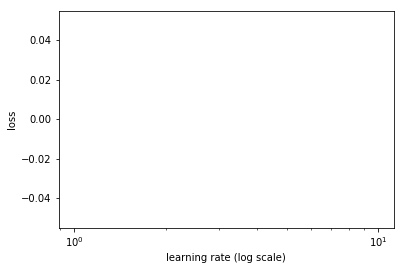

In [128]:
m.sched.plot(100)

### Sample

In [129]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [130]:
m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                  
    0      nan        nan        nan       
    1      nan        nan        nan                       
    2      nan        nan        nan                        



[nan, nan]

In [131]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                  
    0      nan        nan        nan       
    1      nan        nan        nan                        
    2      nan        nan        nan                        
    3      nan        nan        nan                        
    4      nan        nan        nan                        



[nan, nan]

In [133]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=4)

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   exp_rmspe                  
    0      nan        nan        nan       
    1      nan        nan        nan                        
    2      nan        nan        nan                        
    3      nan        nan        nan                        
    4      nan        nan        nan                        
    5      nan        nan        nan                        
    6      nan        nan        nan                        
    7      nan        nan        nan                        



[nan, nan]

In [134]:
m.lr_find()
m.sched.plot()

RuntimeError: cuda runtime error (4) : unspecified launch failure at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/csrc/generic/serialization.cpp:38

### All

In [133]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [136]:
m.fit(0.0001, 1, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))


  2%|▏         | 135/6597 [00:15<12:42,  8.48it/s, loss=0.0115]


  5%|▍         | 320/6597 [00:23<07:37, 13.71it/s, loss=0.0111]


  8%|▊         | 520/6597 [00:28<05:29, 18.47it/s, loss=0.0103]


 11%|█         | 725/6597 [00:32<04:26, 22.02it/s, loss=0.0101]


 14%|█▍        | 925/6597 [00:37<03:51, 24.45it/s, loss=0.0102]


 17%|█▋        | 1124/6597 [00:42<03:28, 26.27it/s, loss=0.00996]


 20%|█▉        | 1317/6597 [00:47<03:11, 27.55it/s, loss=0.0103]


 23%|██▎       | 1517/6597 [00:52<02:56, 28.74it/s, loss=0.00976]


 26%|██▌       | 1714/6597 [00:57<02:44, 29.66it/s, loss=0.00998]


 29%|██▉       | 1910/6597 [01:02<02:34, 30.41it/s, loss=0.00998]


 32%|███▏      | 2108/6597 [01:07<02:24, 31.10it/s, loss=0.0114]


 35%|███▍      | 2303/6597 [01:12<02:15, 31.63it/s, loss=0.00996]


 38%|███▊      | 2497/6597 [01:17<02:07, 32.13it/s, loss=0.0103]


 41%|████      | 2691/6597 [01:22<02:00, 32.54it/s, loss=0.0102]


 44%|████▎     | 2883/6597 [01:27<01:52, 32.88it/s, loss=0.00951]


 47%|████▋     | 3077/6597 [01:32<01:46, 33.21it/s, loss=0.0103]


 50%|████▉     | 3268/6597 [01:37<01:39, 33.46it/s, loss=0.0102]


 52%|█████▏    | 3462/6597 [01:42<01:33, 33.63it/s, loss=0.00997]


 55%|█████▌    | 3658/6597 [01:47<01:26, 33.93it/s, loss=0.00987]


 58%|█████▊    | 3853/6597 [01:52<01:20, 34.19it/s, loss=0.0101]


 61%|██████▏   | 4045/6597 [01:57<01:14, 34.37it/s, loss=0.0101]


 64%|██████▍   | 4239/6597 [02:02<01:08, 34.55it/s, loss=0.00976]


 67%|██████▋   | 4436/6597 [02:07<01:02, 34.75it/s, loss=0.00998]


 70%|███████   | 4629/6597 [02:12<00:56, 34.90it/s, loss=0.01]


 73%|███████▎  | 4824/6597 [02:17<00:50, 35.05it/s, loss=0.00988]


 76%|███████▌  | 5017/6597 [02:22<00:44, 35.15it/s, loss=0.0116]


 79%|███████▉  | 5213/6597 [02:27<00:39, 35.31it/s, loss=0.00959]


 82%|████████▏ | 5410/6597 [02:32<00:33, 35.44it/s, loss=0.0109]


 85%|████████▍ | 5607/6597 [02:37<00:27, 35.58it/s, loss=0.00927]


 88%|████████▊ | 5798/6597 [02:42<00:22, 35.67it/s, loss=0.0106]


 91%|█████████ | 5994/6597 [02:47<00:16, 35.81it/s, loss=0.00953]


 94%|█████████▍| 6191/6597 [02:52<00:11, 35.93it/s, loss=0.00991]


 97%|█████████▋| 6386/6597 [02:57<00:05, 36.02it/s, loss=0.00926]


100%|█████████▉| 6580/6597 [03:02<00:00, 36.12it/s, loss=0.0094]


100%|█████████▉| 6594/6597 [03:02<00:00, 36.10it/s, loss=0.00923]
                                                                 [ 0.       0.00923  0.       0.00016]



In [138]:
0.0001
m.fit(0.0001, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))


  2%|▏         | 135/6597 [00:15<12:35,  8.55it/s, loss=0.00733]


  5%|▍         | 316/6597 [00:23<07:42, 13.57it/s, loss=0.00808]


  8%|▊         | 513/6597 [00:28<05:33, 18.26it/s, loss=0.00778]


 11%|█         | 713/6597 [00:32<04:29, 21.81it/s, loss=0.00719]


 14%|█▍        | 913/6597 [00:37<03:52, 24.42it/s, loss=0.00747]


 17%|█▋        | 1113/6597 [00:41<03:26, 26.60it/s, loss=0.007]  


 20%|█▉        | 1308/6597 [00:46<03:07, 28.22it/s, loss=0.007]  


 23%|██▎       | 1508/6597 [00:50<02:52, 29.59it/s, loss=0.00726]


 26%|██▌       | 1703/6597 [00:55<02:39, 30.65it/s, loss=0.0073] 


 29%|██▉       | 1898/6597 [01:00<02:28, 31.56it/s, loss=0.00775]


 32%|███▏      | 2098/6597 [01:04<02:18, 32.42it/s, loss=0.0078]


 35%|███▍      | 2291/6597 [01:09<02:10, 32.91it/s, loss=0.00732]


 38%|███▊      | 2482/6597 [01:14<02:03, 33.29it/s, loss=0.00752]


 41%|████      | 2675/6597 [01:19<01:56, 33.65it/s, loss=0.00778]


 43%|████▎     | 2868/6597 [01:24<01:49, 33.98it/s, loss=0.00704]


 46%|████▋     | 3057/6597 [01:29<01:43, 34.22it/s, loss=0.00702]


 49%|████▉     | 3251/6597 [01:34<01:37, 34.45it/s, loss=0.00677]


 52%|█████▏    | 3444/6597 [01:39<01:30, 34.70it/s, loss=0.00748]


 55%|█████▌    | 3636/6597 [01:44<01:24, 34.89it/s, loss=0.00675]


 58%|█████▊    | 3827/6597 [01:49<01:19, 35.06it/s, loss=0.00718]


 61%|██████    | 4018/6597 [01:54<01:13, 35.23it/s, loss=0.00697]


 64%|██████▍   | 4208/6597 [01:59<01:07, 35.34it/s, loss=0.00698]


 67%|██████▋   | 4401/6597 [02:03<01:01, 35.50it/s, loss=0.00752]


 70%|██████▉   | 4600/6597 [02:08<00:55, 35.74it/s, loss=0.00698]


 73%|███████▎  | 4795/6597 [02:13<00:50, 35.96it/s, loss=0.00761]


 76%|███████▌  | 4990/6597 [02:17<00:44, 36.16it/s, loss=0.00678]


 79%|███████▊  | 5190/6597 [02:22<00:38, 36.42it/s, loss=0.00682]


 82%|████████▏ | 5385/6597 [02:27<00:33, 36.59it/s, loss=0.00674]


 85%|████████▍ | 5584/6597 [02:31<00:27, 36.79it/s, loss=0.00659]


 88%|████████▊ | 5779/6597 [02:36<00:22, 36.97it/s, loss=0.00665]


 91%|█████████ | 5974/6597 [02:41<00:16, 37.10it/s, loss=0.00668]


 94%|█████████▎| 6173/6597 [02:45<00:11, 37.29it/s, loss=0.00711]


 97%|█████████▋| 6368/6597 [02:50<00:06, 37.43it/s, loss=0.00717]


 99%|█████████▉| 6563/6597 [02:54<00:00, 37.56it/s, loss=0.00666]


100%|█████████▉| 6593/6597 [02:55<00:00, 37.59it/s, loss=0.00678]
                                                                 [ 0.       0.00678  0.00021  0.01445]

  2%|▏         | 110/6597 [00:13<13:44,  7.86it/s, loss=0.00639]


  4%|▍         | 286/6597 [00:21<07:59, 13.15it/s, loss=0.00712]


  7%|▋         | 486/6597 [00:26<05:32, 18.40it/s, loss=0.00679]


 10%|█         | 686/6597 [00:31<04:27, 22.11it/s, loss=0.0066] 


 13%|█▎        | 886/6597 [00:35<03:49, 24.89it/s, loss=0.00619]


 16%|█▋        | 1081/6597 [00:40<03:25, 26.87it/s, loss=0.00662]


 19%|█▉        | 1282/6597 [00:44<03:05, 28.67it/s, loss=0.00651]


 22%|██▏       | 1477/6597 [00:49<02:51, 29.89it/s, loss=0.00649]


 25%|██▌       | 1672/6597 [00:54<02:39, 30.92it/s, loss=0.00712]


 28%|██▊       | 1867/6597 [00:58<02:28, 31.78it/s, loss=0.00665]


 31%|███▏      | 2067/6597 [01:03<02:18, 32.60it/s, loss=0.0067]


 34%|███▍      | 2262/6597 [01:08<02:10, 33.22it/s, loss=0.00687]


 37%|███▋      | 2456/6597 [01:13<02:03, 33.63it/s, loss=0.00646]


 40%|████      | 2648/6597 [01:17<01:56, 34.00it/s, loss=0.0065] 


 43%|████▎     | 2845/6597 [01:22<01:49, 34.37it/s, loss=0.00759]


 46%|████▌     | 3040/6597 [01:27<01:42, 34.73it/s, loss=0.00724]


 49%|████▉     | 3239/6597 [01:32<01:35, 35.09it/s, loss=0.00673]


 52%|█████▏    | 3434/6597 [01:36<01:29, 35.46it/s, loss=0.00666]


 55%|█████▌    | 3629/6597 [01:41<01:22, 35.78it/s, loss=0.00662]


 58%|█████▊    | 3827/6597 [01:46<01:16, 36.06it/s, loss=0.00679]


 61%|██████    | 4022/6597 [01:50<01:10, 36.31it/s, loss=0.00749]


 64%|██████▍   | 4218/6597 [01:55<01:05, 36.51it/s, loss=0.00689]


 67%|██████▋   | 4416/6597 [02:00<00:59, 36.70it/s, loss=0.00685]


 70%|██████▉   | 4608/6597 [02:05<00:54, 36.80it/s, loss=0.00655]


 73%|███████▎  | 4802/6597 [02:10<00:48, 36.89it/s, loss=0.00665]


 76%|███████▌  | 4991/6597 [02:15<00:43, 36.94it/s, loss=0.00679]


 79%|███████▊  | 5185/6597 [02:20<00:38, 37.02it/s, loss=0.00711]


 81%|████████▏ | 5376/6597 [02:25<00:32, 37.05it/s, loss=0.00867]


 84%|████████▍ | 5568/6597 [02:30<00:27, 37.12it/s, loss=0.00642]


 87%|████████▋ | 5760/6597 [02:34<00:22, 37.17it/s, loss=0.00638]


 90%|█████████ | 5951/6597 [02:39<00:17, 37.21it/s, loss=0.00661]


 93%|█████████▎| 6146/6597 [02:44<00:12, 37.28it/s, loss=0.00719]


 96%|█████████▌| 6336/6597 [02:49<00:06, 37.31it/s, loss=0.00678]


 99%|█████████▉| 6527/6597 [02:54<00:01, 37.35it/s, loss=0.00669]


100%|██████████| 6597/6597 [02:56<00:00, 37.35it/s, loss=0.00664]
                                                                 [ 1.       0.00664  0.00094  0.03016]

  1%|          | 78/6597 [00:10<15:12,  7.14it/s, loss=0.00648]


  3%|▎         | 221/6597 [00:23<11:11,  9.49it/s, loss=0.0069] 


  6%|▋         | 414/6597 [00:28<07:03, 14.59it/s, loss=0.00692]


  9%|▉         | 611/6597 [00:33<05:27, 18.31it/s, loss=0.00663]


 12%|█▏        | 806/6597 [00:38<04:35, 21.00it/s, loss=0.00664]


 15%|█▌        | 1001/6597 [00:43<04:02, 23.06it/s, loss=0.00669]


 18%|█▊        | 1193/6597 [00:48<03:38, 24.68it/s, loss=0.00617]


 21%|██        | 1385/6597 [00:53<03:20, 25.99it/s, loss=0.00698]


 24%|██▍       | 1574/6597 [00:58<03:05, 27.02it/s, loss=0.00678]


 27%|██▋       | 1768/6597 [01:03<02:52, 27.98it/s, loss=0.00706]


 30%|██▉       | 1960/6597 [01:08<02:41, 28.79it/s, loss=0.00652]


 33%|███▎      | 2153/6597 [01:13<02:30, 29.49it/s, loss=0.00651]


 36%|███▌      | 2347/6597 [01:17<02:21, 30.11it/s, loss=0.00672]


 38%|███▊      | 2537/6597 [01:22<02:12, 30.57it/s, loss=0.00663]


 41%|████▏     | 2726/6597 [01:28<02:05, 30.95it/s, loss=0.00655]


 44%|████▍     | 2917/6597 [01:33<01:57, 31.32it/s, loss=0.00647]


 47%|████▋     | 3108/6597 [01:38<01:50, 31.65it/s, loss=0.00635]


 50%|█████     | 3302/6597 [01:43<01:42, 32.03it/s, loss=0.00667]


 53%|█████▎    | 3494/6597 [01:48<01:35, 32.33it/s, loss=0.0071] 


 56%|█████▌    | 3685/6597 [01:53<01:29, 32.60it/s, loss=0.00707]


 59%|█████▉    | 3878/6597 [01:57<01:22, 32.87it/s, loss=0.00669]


 62%|██████▏   | 4073/6597 [02:02<01:16, 33.15it/s, loss=0.00643]


 65%|██████▍   | 4264/6597 [02:07<01:09, 33.37it/s, loss=0.00636]


 68%|██████▊   | 4456/6597 [02:12<01:03, 33.56it/s, loss=0.00693]


 70%|███████   | 4647/6597 [02:17<00:57, 33.73it/s, loss=0.0067] 


 73%|███████▎  | 4839/6597 [02:22<00:51, 33.92it/s, loss=0.00763]


 76%|███████▋  | 5033/6597 [02:27<00:45, 34.09it/s, loss=0.00642]


 79%|███████▉  | 5226/6597 [02:32<00:40, 34.26it/s, loss=0.00877]


 82%|████████▏ | 5417/6597 [02:37<00:34, 34.40it/s, loss=0.00645]


 85%|████████▍ | 5606/6597 [02:42<00:28, 34.52it/s, loss=0.00631]


 88%|████████▊ | 5801/6597 [02:47<00:22, 34.66it/s, loss=0.00626]


 91%|█████████ | 5997/6597 [02:52<00:17, 34.82it/s, loss=0.00688]


 94%|█████████▍| 6187/6597 [02:57<00:11, 34.92it/s, loss=0.00667]


 97%|█████████▋| 6382/6597 [03:02<00:06, 35.05it/s, loss=0.0065]


100%|█████████▉| 6574/6597 [03:07<00:00, 35.15it/s, loss=0.00623]


100%|█████████▉| 6596/6597 [03:07<00:00, 35.17it/s, loss=0.0062] 
                                                                [ 2.       0.0062   0.00116  0.03353]



In [139]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))


  2%|▏         | 132/6597 [00:15<12:54,  8.35it/s, loss=0.00616]


  5%|▍         | 298/6597 [00:26<09:14, 11.35it/s, loss=0.00614]


  7%|▋         | 490/6597 [00:31<06:30, 15.65it/s, loss=0.00754]


 10%|█         | 686/6597 [00:36<05:15, 18.75it/s, loss=0.00915]


 13%|█▎        | 880/6597 [00:41<04:30, 21.11it/s, loss=0.00845]


 16%|█▋        | 1077/6597 [00:46<03:59, 23.09it/s, loss=0.00815]


 19%|█▉        | 1271/6597 [00:51<03:36, 24.65it/s, loss=0.00833]


 22%|██▏       | 1461/6597 [00:56<03:18, 25.84it/s, loss=0.0077]


 25%|██▌       | 1651/6597 [01:01<03:04, 26.83it/s, loss=0.008]


 28%|██▊       | 1843/6597 [01:06<02:51, 27.69it/s, loss=0.0079]


 31%|███       | 2036/6597 [01:11<02:40, 28.47it/s, loss=0.00783]


 34%|███▎      | 2225/6597 [01:16<02:30, 29.11it/s, loss=0.00815]


 37%|███▋      | 2420/6597 [01:21<02:20, 29.74it/s, loss=0.00829]


 40%|███▉      | 2612/6597 [01:26<02:11, 30.27it/s, loss=0.00742]


 43%|████▎     | 2806/6597 [01:30<02:02, 30.85it/s, loss=0.00789]


 45%|████▌     | 2999/6597 [01:35<01:55, 31.28it/s, loss=0.0104]


 48%|████▊     | 3194/6597 [01:40<01:47, 31.70it/s, loss=0.00752]


 51%|█████▏    | 3388/6597 [01:45<01:40, 32.05it/s, loss=0.00776]


 54%|█████▍    | 3583/6597 [01:50<01:33, 32.41it/s, loss=0.00742]


 57%|█████▋    | 3774/6597 [01:55<01:26, 32.68it/s, loss=0.00784]


 60%|██████    | 3967/6597 [02:00<01:19, 32.96it/s, loss=0.00689]


 63%|██████▎   | 4159/6597 [02:05<01:13, 33.20it/s, loss=0.00746]


 66%|██████▌   | 4355/6597 [02:10<01:07, 33.43it/s, loss=0.00689]


 69%|██████▉   | 4547/6597 [02:15<01:00, 33.62it/s, loss=0.00721]


 72%|███████▏  | 4738/6597 [02:20<00:55, 33.80it/s, loss=0.00691]


 75%|███████▍  | 4929/6597 [02:25<00:49, 33.97it/s, loss=0.00707]


 78%|███████▊  | 5122/6597 [02:30<00:43, 34.14it/s, loss=0.00689]


 81%|████████  | 5316/6597 [02:34<00:37, 34.34it/s, loss=0.00752]


 84%|████████▎ | 5511/6597 [02:39<00:31, 34.50it/s, loss=0.00705]


 86%|████████▋ | 5704/6597 [02:44<00:25, 34.64it/s, loss=0.0077]


 89%|████████▉ | 5896/6597 [02:49<00:20, 34.77it/s, loss=0.00698]


 92%|█████████▏| 6092/6597 [02:54<00:14, 34.91it/s, loss=0.00649]


 95%|█████████▌| 6284/6597 [02:59<00:08, 35.03it/s, loss=0.00665]


 98%|█████████▊| 6479/6597 [03:04<00:03, 35.15it/s, loss=0.00633]


100%|██████████| 6597/6597 [03:07<00:00, 35.22it/s, loss=0.00649]
                                                                 [ 0.       0.00649  0.00002  0.00421]

  1%|          | 50/6597 [00:07<15:35,  7.00it/s, loss=0.00695]


  3%|▎         | 180/6597 [00:21<12:36,  8.48it/s, loss=0.00774]


  6%|▌         | 377/6597 [00:26<07:10, 14.44it/s, loss=0.0088] 


  9%|▊         | 571/6597 [00:31<05:28, 18.35it/s, loss=0.0088] 


 12%|█▏        | 769/6597 [00:36<04:33, 21.29it/s, loss=0.00851]


 15%|█▍        | 967/6597 [00:41<03:59, 23.52it/s, loss=0.0082] 


 18%|█▊        | 1160/6597 [00:46<03:35, 25.19it/s, loss=0.00776]


 20%|██        | 1351/6597 [00:50<03:18, 26.49it/s, loss=0.00781]


 23%|██▎       | 1543/6597 [00:55<03:03, 27.60it/s, loss=0.0084] 


 26%|██▋       | 1737/6597 [01:00<02:50, 28.56it/s, loss=0.00762]


 29%|██▉       | 1930/6597 [01:05<02:39, 29.34it/s, loss=0.00783]


 32%|███▏      | 2122/6597 [01:10<02:29, 30.03it/s, loss=0.00812]


 35%|███▌      | 2319/6597 [01:15<02:19, 30.70it/s, loss=0.00797]


 38%|███▊      | 2509/6597 [01:20<02:11, 31.18it/s, loss=0.00772]


 41%|████      | 2704/6597 [01:25<02:02, 31.67it/s, loss=0.0082] 


 44%|████▍     | 2899/6597 [01:30<01:55, 32.11it/s, loss=0.00736]


 47%|████▋     | 3090/6597 [01:35<01:48, 32.41it/s, loss=0.00783]


 50%|████▉     | 3283/6597 [01:40<01:41, 32.75it/s, loss=0.00697]


 53%|█████▎    | 3478/6597 [01:45<01:34, 33.08it/s, loss=0.0072]


 56%|█████▌    | 3667/6597 [01:50<01:27, 33.31it/s, loss=0.00716]


 59%|█████▊    | 3864/6597 [01:55<01:21, 33.60it/s, loss=0.00671]


 61%|██████▏   | 4056/6597 [01:59<01:15, 33.82it/s, loss=0.00689]


 64%|██████▍   | 4249/6597 [02:04<01:08, 34.03it/s, loss=0.00674]


 67%|██████▋   | 4442/6597 [02:09<01:02, 34.24it/s, loss=0.00665]


 70%|███████   | 4637/6597 [02:14<00:56, 34.44it/s, loss=0.00678]


 73%|███████▎  | 4832/6597 [02:19<00:50, 34.62it/s, loss=0.00647]


 76%|███████▌  | 5019/6597 [02:24<00:45, 34.73it/s, loss=0.00637]


 79%|███████▉  | 5210/6597 [02:29<00:39, 34.86it/s, loss=0.00676]


 82%|████████▏ | 5405/6597 [02:34<00:34, 35.02it/s, loss=0.00711]


 85%|████████▍ | 5599/6597 [02:39<00:28, 35.17it/s, loss=0.00679]


 88%|████████▊ | 5793/6597 [02:44<00:22, 35.31it/s, loss=0.00685]


 91%|█████████ | 5985/6597 [02:48<00:17, 35.42it/s, loss=0.00741]


 94%|█████████▎| 6180/6597 [02:53<00:11, 35.55it/s, loss=0.00696]


 97%|█████████▋| 6373/6597 [02:58<00:06, 35.65it/s, loss=0.00679]


100%|█████████▉| 6566/6597 [03:03<00:00, 35.74it/s, loss=0.00666]


100%|█████████▉| 6595/6597 [03:04<00:00, 35.76it/s, loss=0.00679]
                                                                 [ 1.       0.00679  0.00005  0.00731]

  2%|▏         | 108/6597 [00:13<13:59,  7.73it/s, loss=0.00748]


  4%|▍         | 265/6597 [00:23<09:27, 11.16it/s, loss=0.00797]


  7%|▋         | 464/6597 [00:28<06:19, 16.15it/s, loss=0.00768]


 10%|█         | 660/6597 [00:33<05:03, 19.58it/s, loss=0.00792]


 13%|█▎        | 855/6597 [00:38<04:19, 22.10it/s, loss=0.00863]


 16%|█▌        | 1053/6597 [00:43<03:49, 24.15it/s, loss=0.00807]


 19%|█▉        | 1245/6597 [00:48<03:28, 25.67it/s, loss=0.00786]


 22%|██▏       | 1441/6597 [00:53<03:11, 26.97it/s, loss=0.00787]


 25%|██▍       | 1632/6597 [00:58<02:57, 27.96it/s, loss=0.00728]


 28%|██▊       | 1823/6597 [01:03<02:45, 28.79it/s, loss=0.00781]


 31%|███       | 2015/6597 [01:08<02:35, 29.53it/s, loss=0.0071] 


 34%|███▎      | 2210/6597 [01:13<02:25, 30.23it/s, loss=0.00787]


 36%|███▋      | 2405/6597 [01:17<02:15, 30.84it/s, loss=0.00746]


 39%|███▉      | 2596/6597 [01:22<02:07, 31.30it/s, loss=0.00731]


 42%|████▏     | 2789/6597 [01:27<01:59, 31.74it/s, loss=0.00765]


 45%|████▌     | 2980/6597 [01:32<01:52, 32.16it/s, loss=0.00713]


 48%|████▊     | 3173/6597 [01:37<01:45, 32.48it/s, loss=0.00722]


 51%|█████     | 3366/6597 [01:42<01:38, 32.80it/s, loss=0.0071] 


 54%|█████▍    | 3562/6597 [01:47<01:31, 33.13it/s, loss=0.00784]


 57%|█████▋    | 3753/6597 [01:52<01:25, 33.38it/s, loss=0.00705]


 60%|█████▉    | 3945/6597 [01:57<01:18, 33.61it/s, loss=0.00686]


 63%|██████▎   | 4145/6597 [02:01<01:12, 33.99it/s, loss=0.00686]


 66%|██████▌   | 4340/6597 [02:06<01:05, 34.25it/s, loss=0.00706]


 69%|██████▊   | 4535/6597 [02:11<00:59, 34.53it/s, loss=0.00687]


 72%|███████▏  | 4730/6597 [02:16<00:53, 34.78it/s, loss=0.0068] 


 75%|███████▍  | 4929/6597 [02:20<00:47, 35.04it/s, loss=0.00667]


 78%|███████▊  | 5124/6597 [02:25<00:41, 35.27it/s, loss=0.00673]


 81%|████████  | 5324/6597 [02:29<00:35, 35.54it/s, loss=0.00642]


 84%|████████▎ | 5519/6597 [02:34<00:30, 35.69it/s, loss=0.00749]


 87%|████████▋ | 5712/6597 [02:39<00:24, 35.80it/s, loss=0.00661]


 89%|████████▉ | 5903/6597 [02:44<00:19, 35.89it/s, loss=0.00674]


 92%|█████████▏| 6095/6597 [02:49<00:13, 35.99it/s, loss=0.00658]


 95%|█████████▌| 6292/6597 [02:54<00:08, 36.11it/s, loss=0.00696]


 98%|█████████▊| 6485/6597 [02:59<00:03, 36.19it/s, loss=0.00643]


100%|█████████▉| 6595/6597 [03:01<00:00, 36.24it/s, loss=0.00641]
                                                                 [ 2.       0.00641  0.00005  0.00671]



### Test

In [185]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [102]:
m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.01413  0.0063   0.07628]                           
[ 1.       0.01022  0.00859  0.08851]                           
[ 2.       0.00932  0.00001  0.00243]                            



In [103]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.00748  0.       0.00167]                            
[ 1.       0.00717  0.00009  0.00947]                            
[ 2.       0.00643  0.00013  0.01147]                            



In [105]:
m.save('val0')

In [186]:
m.load('val0')

In [187]:
x,y=m.predict_with_targs()

In [188]:
exp_rmspe(x,y)

0.01147316926177568

In [189]:
pred_test=m.predict(True)

In [190]:
pred_test = np.exp(pred_test)

In [192]:
joined_test['Sales']=pred_test

In [193]:
csv_fn=f'{PATH}tmp/sub.csv'

In [200]:
joined_test[['Id','Sales']].to_csv(csv_fn, index=False)

In [202]:
FileLink(csv_fn)

/home/ubuntu/fastai/courses/dl1/data/rossmann/tmp/sub.csv

## RF

In [101]:
from sklearn.ensemble import RandomForestRegressor

In [102]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, yl)

In [103]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [104]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(preds, y_val)

(0.98086411192483902,
 0.92614447508562714,
 0.9193358549649463,
 0.11557443993375387)